# Learning a quadratic prior

This code attempts to learn a concave quadratic prior $J(x) = -\frac{1}{4}||x||_2^2$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian $H(p) = \frac{1}{2}||p||_2^2$.
The LPN learns the function $\psi(x) = ||x||_2^2$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/concave_quadratic_prior_8D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

In [2]:
# Parameters
# --- Parameters fof Experiment ---
dim_exp = 8  # Dimension (e.g., 2D, 4D, 8D as in the paper)
data_points_exp = 30000 # Example number of data points
iterations_exp_initial = 1 # Iterations for initial training phase
iterations_exp_long = 100000 # Iterations for longer training phase
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 50 # For plotting cross-sections


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 2       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers
#eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

# === Section ===

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Section 4.1.2: L1 Prior Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def cvx_true_concave_quad(y_points): # y_points is N x dim
    """
    Computes the target function psi(y) = ||y||_2^2 for the given problem.
    """
    return euclid_norm_sq(y_points)

def prior_true_concave_quad(x_points):
    """
    Computes the true concave prior J(x) = -1/4 * ||x||_2^2.
    """
    return -0.25 * euclid_norm_sq(x_points)

def invert_prior_lpn(x, model, INVERT_MODE):
    y = invert(x,model,INVERT_MODE)
    return y

def evaluate_learned_prior_lpn(x_eval_points, y_inverted_points, model):
    try:
        y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
    except NameError: 
        print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
        y_tensor = torch.from_numpy(y_inverted_points).float()
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
    prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
    return prior_est


def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    x1_0_psi_true = cvx_true_concave_quad(x1_0_points)
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_concave_quad(x2_0_points)
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else: 
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true
        
    x1_0_psi_est = cvx(x1_0_points, model) 
    y1_inverted = invert_prior_lpn(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_prior_lpn(x1_0_points,y1_inverted, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        y2_inverted = invert_prior_lpn(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_prior_lpn(x2_0_points,y2_inverted, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
        
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"$\\psi(y_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$y_1$')
    plt.ylabel('$\\psi(y_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2) # Second plot for psi if dim > 1
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"$\\psi(0,y_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$y_2$')
        plt.ylabel('$\\psi(0,y_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_concave_quad(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim={dim}) ---")
    cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim)



In [4]:
def evaluate_learned_H(model, a, spacing, dim):
    """
    Calculates and plots the approximate Hamiltonian H_theta.
    H_theta(p) = max_k { <p, eta_k> - b_k }
    where eta_k = x_k - grad_psi(x_k) and b_k = 0.5 * ||eta_k||^2
    """
    x_k_np = np.random.uniform(-a, a, (data_points_exp, dim))
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    x_k_tensor.requires_grad_(True)
    grad_psi_k_tensor = model(x_k_tensor)

    eta_k_tensor = x_k_tensor - grad_psi_k_tensor
    b_k_tensor = 0.5 * torch.sum(eta_k_tensor**2, dim=1, keepdim=True)

    xi = np.linspace(-a, a, spacing)
    p_eval_points_np = np.zeros((xi.size, dim))
    p_eval_points_np[:, 0] = xi
    p_eval_tensor = torch.from_numpy(p_eval_points_np).float().to(device)

    # Compute H_theta(p) for the cross-section
    inner_prods = torch.matmul(p_eval_tensor, eta_k_tensor.T)  # (spacing x data_points)
    H_theta_p_tensor = torch.max(inner_prods - b_k_tensor.T, dim=1, keepdim=True)[0]
    H_theta_p_np = H_theta_p_tensor.detach().cpu().numpy().flatten()

    # Compute true Hamiltonian H(p) = 0.5 * ||p||^2
    H_true_p_np = 0.5 * euclid_norm_sq(p_eval_points_np)

    plt.figure(figsize=(6,5))
    plt.plot(xi, H_theta_p_np, "-", label="Learned Hamiltonian $H_{\\theta}(p_1,0,...)$")
    plt.plot(xi, H_true_p_np, "--", label="True Hamiltonian $H(p)=1/2||p||_2^2$")
    plt.grid(True)
    plt.title(f"Hamiltonian Comparison - Dim {dim}")
    plt.xlabel('$p_1$')
    plt.ylabel('H(p)')
    plt.legend()
    plt.tight_layout()
    plt.show()


# --- Generate Training Data

In [5]:
# --- Generate Training Data for the new experiment ---
print("--- Generating Training Data for Concave Quadratic Prior ---")
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))
psi_samples_exp_np = cvx_true_concave_quad(y_j_exp_np)
psi_samples_exp_np = psi_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float().to(device)
psi_samples_exp_tensor = torch.from_numpy(psi_samples_exp_np).float().to(device)
print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, psi_samples_exp_tensor shape {psi_samples_exp_tensor.shape}")

# --- ADD THIS TO MOVE DATA TO GPU ---
y_j_exp_tensor = y_j_exp_tensor.to(device)
psi_samples_exp_tensor = psi_samples_exp_tensor.to(device)

--- Generating Training Data for Concave Quadratic Prior ---


Generated training data: y_j_exp_tensor shape torch.Size([30000, 8]), psi_samples_exp_tensor shape torch.Size([30000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    #elif loss_type == 0:
    #    loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [7]:

# --- Train and Plot with L2 Loss for the new experiment ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad_l2 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad = torch.optim.Adam(lpn_model_concave_quad_l2.parameters(), lr=1e-4)

# Initial shorter training phase with a higher learning rate
for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

# Longer training phase with a reduced learning rate
for g in optimizer_concave_quad.param_groups:
    g["lr"] = 1e-4
for i in range(iterations_exp_long):
    if (i % 20000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_concave_quad.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_concave_quad_l2.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l2.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---


iteration 0 loss 2036.197509765625
iteration 0 loss 90.18318176269531


iteration 500 loss 63.888641357421875


iteration 1000 loss 48.11243438720703


iteration 1500 loss 35.03350067138672


iteration 2000 loss 24.71013069152832


iteration 2500 loss 16.4572696685791


iteration 3000 loss 10.139817237854004


iteration 3500 loss 5.942563533782959


iteration 4000 loss 3.3909945487976074


iteration 4500 loss 1.8826193809509277


iteration 5000 loss 1.0519828796386719


iteration 5500 loss 0.6418681144714355


iteration 6000 loss 0.4267328679561615


iteration 6500 loss 0.3032199442386627


iteration 7000 loss 0.2209920883178711


iteration 7500 loss 0.18991497159004211


iteration 8000 loss 0.17001868784427643


iteration 8500 loss 0.1501987874507904


iteration 9000 loss 0.13100391626358032


iteration 9500 loss 0.11317945271730423


iteration 10000 loss 0.0971798300743103


iteration 10500 loss 0.08333813399076462


iteration 11000 loss 0.0787288248538971


iteration 11500 loss 0.07661687582731247


iteration 12000 loss 0.07424786686897278


iteration 12500 loss 0.07152475416660309


iteration 13000 loss 0.06843734532594681


iteration 13500 loss 0.06500908732414246


iteration 14000 loss 0.06128324195742607


iteration 14500 loss 0.05732746794819832


iteration 15000 loss 0.09572163224220276


iteration 15500 loss 0.05327889323234558


iteration 16000 loss 0.05257972329854965


iteration 16500 loss 0.05186157673597336


iteration 17000 loss 0.051008619368076324


iteration 17500 loss 0.04997829720377922


iteration 18000 loss 0.048731762915849686


iteration 18500 loss 0.04723280668258667


iteration 19000 loss 0.04548041149973869


iteration 19500 loss 0.043385010212659836


Learning rate decreased to 1e-05 at iteration 20000
iteration 20000 loss 0.04283275082707405


iteration 20500 loss 0.042761996388435364


iteration 21000 loss 0.042674437165260315


iteration 21500 loss 0.04256390035152435


iteration 22000 loss 0.04242517054080963


iteration 22500 loss 0.04225074127316475


iteration 23000 loss 0.04203129932284355


iteration 23500 loss 0.04175616800785065


iteration 24000 loss 0.04141209274530411


iteration 24500 loss 0.04098460078239441


iteration 25000 loss 0.040458470582962036


iteration 25500 loss 0.039820414036512375


iteration 26000 loss 0.03905723989009857


iteration 26500 loss 0.038160890340805054


iteration 27000 loss 0.03712913766503334


iteration 27500 loss 0.0363842248916626


iteration 28000 loss 0.036158788949251175


iteration 28500 loss 0.03587950021028519


iteration 29000 loss 0.035533465445041656


iteration 29500 loss 0.03510888293385506


iteration 30000 loss 0.03459463268518448


iteration 30500 loss 0.033983152359724045


iteration 31000 loss 0.03326839581131935


iteration 31500 loss 0.03245041146874428


iteration 32000 loss 0.03212375193834305


iteration 32500 loss 0.03194541856646538


iteration 33000 loss 0.031722262501716614


iteration 33500 loss 0.03144475445151329


iteration 34000 loss 0.031103035435080528


iteration 34500 loss 0.0306873582303524


iteration 35000 loss 0.030189339071512222


iteration 35500 loss 0.02960323542356491


iteration 36000 loss 0.047934383153915405


iteration 36500 loss 0.028811870142817497


iteration 37000 loss 0.02865997888147831


iteration 37500 loss 0.028469830751419067


iteration 38000 loss 0.028233520686626434


iteration 38500 loss 0.027942650020122528


iteration 39000 loss 0.02758829854428768


iteration 39500 loss 0.02716309018433094


Learning rate decreased to 1.0000000000000002e-06 at iteration 40000
iteration 40000 loss 0.026661768555641174


iteration 40500 loss 0.02660241723060608


iteration 41000 loss 0.026531333103775978


iteration 41500 loss 0.026447869837284088


iteration 42000 loss 0.02635156735777855


iteration 42500 loss 0.026241792365908623


iteration 43000 loss 0.026119103655219078


iteration 43500 loss 0.02598419599235058


iteration 44000 loss 0.025836531072854996


iteration 44500 loss 0.025678027421236038


iteration 45000 loss 0.02551100216805935


iteration 45500 loss 0.02535022795200348


iteration 46000 loss 0.025193676352500916


iteration 46500 loss 0.02503945305943489


iteration 47000 loss 0.024892011657357216


iteration 47500 loss 0.024744197726249695


iteration 48000 loss 0.024600733071565628


iteration 48500 loss 0.024460339918732643


iteration 49000 loss 0.024318138137459755


iteration 49500 loss 0.024190258234739304


iteration 50000 loss 0.024052970111370087


iteration 50500 loss 0.023921042680740356


iteration 51000 loss 0.02379744127392769


iteration 51500 loss 0.023664643988013268


iteration 52000 loss 0.02354012057185173


iteration 52500 loss 0.023424435406923294


iteration 53000 loss 0.02329949289560318


iteration 53500 loss 0.023170512169599533


iteration 54000 loss 0.02306317165493965


iteration 54500 loss 0.02294674515724182


iteration 55000 loss 0.022821683436632156


iteration 55500 loss 0.022709663957357407


iteration 56000 loss 0.022598564624786377


iteration 56500 loss 0.02247880958020687


iteration 57000 loss 0.022366652265191078


iteration 57500 loss 0.022261861711740494


iteration 58000 loss 0.02214846760034561


iteration 58500 loss 0.022031698375940323


iteration 59000 loss 0.021933792158961296


iteration 59500 loss 0.021827632561326027


Learning rate decreased to 1.0000000000000002e-07 at iteration 60000
iteration 60000 loss 0.021713431924581528


iteration 60500 loss 0.021700462326407433


iteration 61000 loss 0.02168666571378708


iteration 61500 loss 0.021671904250979424


iteration 62000 loss 0.021656326949596405


iteration 62500 loss 0.021640092134475708


iteration 63000 loss 0.02162337116897106


iteration 63500 loss 0.021606111899018288


iteration 64000 loss 0.021588489413261414


iteration 64500 loss 0.021570520475506783


iteration 65000 loss 0.021552328020334244


iteration 65500 loss 0.02153395116329193


iteration 66000 loss 0.021515531465411186


iteration 66500 loss 0.02149723470211029


iteration 67000 loss 0.021479038521647453


iteration 67500 loss 0.02146090753376484


iteration 68000 loss 0.02144285850226879


iteration 68500 loss 0.021424902603030205


iteration 69000 loss 0.02140701189637184


iteration 69500 loss 0.021389197558164597


iteration 70000 loss 0.021371452137827873


iteration 70500 loss 0.021353760734200478


iteration 71000 loss 0.021336153149604797


iteration 71500 loss 0.021318582817912102


iteration 72000 loss 0.021301081404089928


iteration 72500 loss 0.021283630281686783


iteration 73000 loss 0.021266257390379906


iteration 73500 loss 0.021248934790492058


iteration 74000 loss 0.021231694146990776


iteration 74500 loss 0.021214457228779793


iteration 75000 loss 0.02119726501405239


iteration 75500 loss 0.021180149167776108


iteration 76000 loss 0.02116307057440281


iteration 76500 loss 0.021146025508642197


iteration 77000 loss 0.021129008382558823


iteration 77500 loss 0.02111203223466873


iteration 78000 loss 0.021095076575875282


iteration 78500 loss 0.021078169345855713


iteration 79000 loss 0.021061310544610023


iteration 79500 loss 0.021044468507170677


Learning rate decreased to 1.0000000000000004e-08 at iteration 80000
iteration 80000 loss 0.021027687937021255


iteration 80500 loss 0.0210269782692194


iteration 81000 loss 0.02102624997496605


iteration 81500 loss 0.02102552354335785


iteration 82000 loss 0.02102477289736271


iteration 82500 loss 0.02102401666343212


iteration 83000 loss 0.021023260429501534


iteration 83500 loss 0.021022506058216095


iteration 84000 loss 0.021021733060479164


iteration 84500 loss 0.02102096751332283


iteration 85000 loss 0.021020209416747093


iteration 85500 loss 0.02101944573223591


iteration 86000 loss 0.02101868949830532


iteration 86500 loss 0.021017910912632942


iteration 87000 loss 0.021017154678702354


iteration 87500 loss 0.021016385406255722


iteration 88000 loss 0.021015649661421776


iteration 88500 loss 0.021014878526329994


iteration 89000 loss 0.02101411111652851


iteration 89500 loss 0.021013358607888222


iteration 90000 loss 0.02101258747279644


iteration 90500 loss 0.021011818200349808


iteration 91000 loss 0.021011101081967354


iteration 91500 loss 0.021010328084230423


iteration 92000 loss 0.021009573712944984


iteration 92500 loss 0.021008821204304695


iteration 93000 loss 0.021008070558309555


iteration 93500 loss 0.021007323637604713


iteration 94000 loss 0.02100658044219017


iteration 94500 loss 0.02100582979619503


iteration 95000 loss 0.02100508287549019


iteration 95500 loss 0.02100432850420475


iteration 96000 loss 0.021003585308790207


iteration 96500 loss 0.021002836525440216


iteration 97000 loss 0.021002084016799927


iteration 97500 loss 0.021001353859901428


iteration 98000 loss 0.02100059762597084


iteration 98500 loss 0.020999858155846596


iteration 99000 loss 0.020999111235141754


iteration 99500 loss 0.020998384803533554


L2 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=8) ---
loss 197.4100341796875


loss 153.68252563476562


loss 124.27940368652344


loss 105.64796447753906


loss 95.3734130859375


loss 90.7264404296875


loss 89.10914611816406


loss 88.70701599121094


loss 88.64173889160156


loss 88.63553619384766


loss 88.63524627685547


loss 88.63523864746094


loss 88.63523864746094


loss 88.63523864746094


loss 88.63523864746094


loss 88.63523864746094


loss 88.63524627685547


loss 88.63523864746094


loss 88.63524627685547


loss 88.63523864746094


loss 88.63523864746094


loss 88.63523864746094


loss 88.63523864746094


loss 88.63523864746094


loss 88.63525390625


loss 88.63523864746094


loss 88.63523864746094


loss 88.63524627685547


loss 88.63524627685547


loss 88.63523864746094


loss 88.63523864746094


loss 88.63524627685547


loss 88.63524627685547


loss 88.63523864746094


loss 88.6352310180664


loss 88.63523864746094


loss 88.63523864746094


loss 88.63523864746094


loss 88.63523864746094


loss 88.63523864746094


final mse:  1.2005308969165185e-09
max, min: 2.4375563 -2.4347231
loss 197.4100341796875


loss 153.6900634765625


loss 124.33799743652344


loss 105.74114227294922


loss 95.47830200195312


loss 90.83175659179688


loss 89.21296691894531


loss 88.81002807617188


loss 88.74455261230469


loss 88.73833465576172


loss 88.73802947998047


loss 88.73802185058594


loss 88.73802185058594


loss 88.73802185058594


loss 88.738037109375


loss 88.73802185058594


loss 88.73802185058594


loss 88.73802185058594


loss 88.73802185058594


loss 88.73802185058594


loss 88.73802185058594


loss 88.73802185058594


loss 88.73802185058594


loss 88.73802185058594


loss 88.73802185058594


loss 88.7380142211914


loss 88.73802185058594


loss 88.73802185058594


loss 88.73802185058594


loss 88.73802185058594


loss 88.7380142211914


loss 88.7380142211914


loss 88.73802185058594


loss 88.73802185058594


loss 88.73802185058594


loss 88.7380142211914


loss 88.73802185058594


loss 88.73802185058594


loss 88.73802185058594


loss 88.73802185058594


final mse:  1.0301360875430987e-09
max, min: 2.427093 -2.4460914


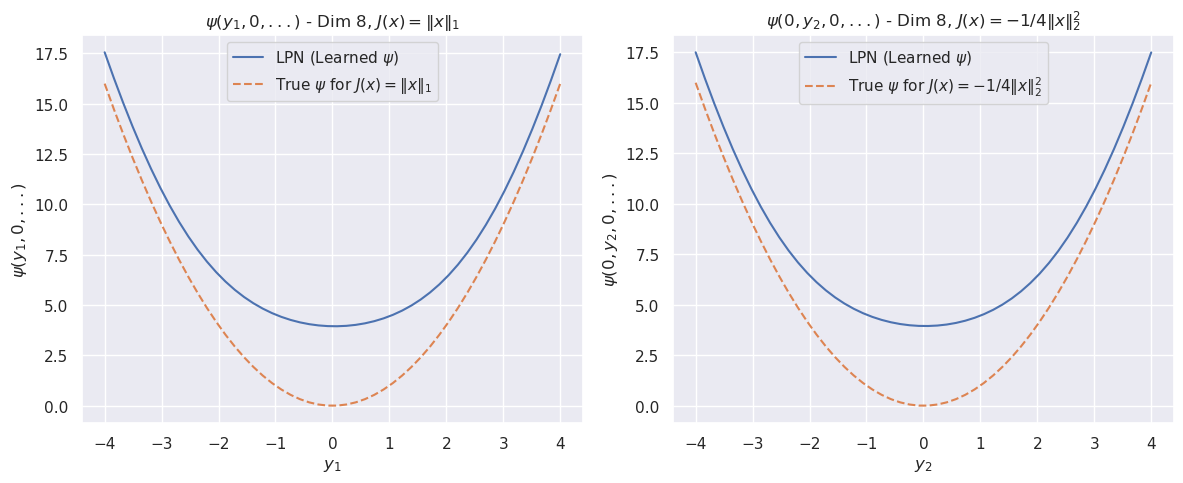

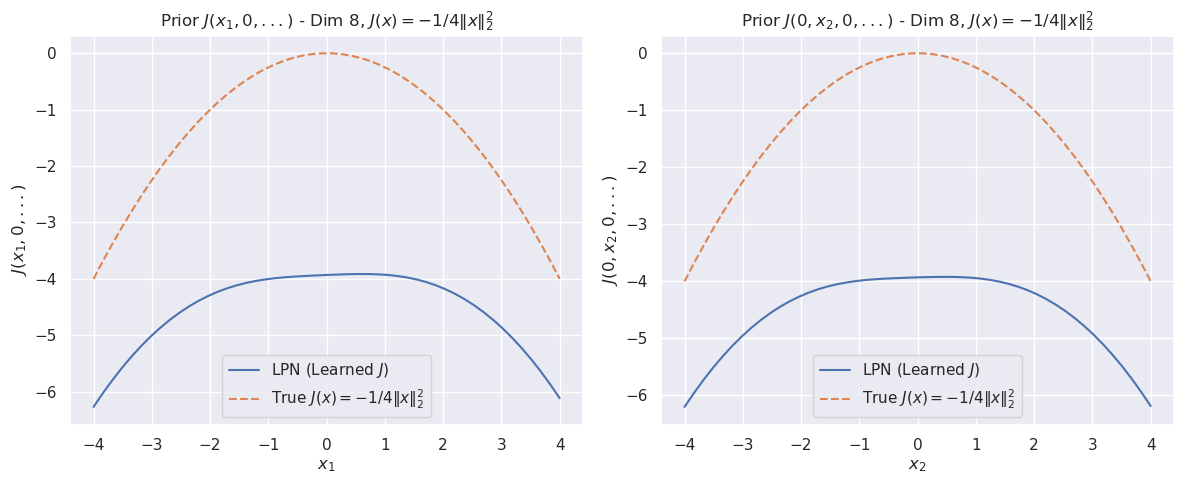

In [8]:
#print("\n--- Plotting Cross Sections for Quadratic H, Concave Quad Prior (Dim=4) ---")
plot_all_concave_quad(lpn_model_concave_quad_l2, a_exp, spacing, INVERT_MODE, dim_exp)

#print("\n--- Plotting Learned Hamiltonian for Quadratic H, Concave Quad Prior ---")
#evaluate_learned_H(lpn_model_concave_quad_l2, a_exp, spacing, dim_exp)

In [9]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = y_j_exp_tensor.clone().to(device)
x_k_tensor.requires_grad_(True)

# 1. Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model_concave_quad_l2.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model_concave_quad_l2(x_k_tensor)

# 2. Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

# Detach the tensor to treat G_k as fixed targets, breaking the connection
# to the first LPN's graph and preventing the RuntimeError during training.
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

# The input tensor x_k_tensor is still needed for the second LPN training,
# but it should also not require a gradient for that training.
x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)
# G_samples_tensor now holds the target values G_k
print(f"Generated G samples: G_samples_tensor shape {G_samples_tensor.shape}")

Generated G samples: G_samples_tensor shape torch.Size([30000, 1])


In [10]:
# --- Step 3: Train LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
# The target for this LPN is G_samples_tensor
# The input for this LPN is x_k_tensor
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-4)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 # Use a smaller learning rate for the long phase
for i in range(iterations_exp_long):
    if (i % 20000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 1900.985107421875
iteration 0 loss 1091.7520751953125


iteration 500 loss 43.27200698852539


iteration 1000 loss 41.93597412109375


iteration 1500 loss 41.07136535644531


iteration 2000 loss 40.17074966430664


iteration 2500 loss 39.073909759521484


iteration 3000 loss 37.7264404296875


iteration 3500 loss 36.05284881591797


iteration 4000 loss 33.916893005371094


iteration 4500 loss 30.989458084106445


iteration 5000 loss 26.44087028503418


iteration 5500 loss 19.000659942626953


iteration 6000 loss 10.889610290527344


iteration 6500 loss 6.202976226806641


iteration 7000 loss 4.322469234466553


iteration 7500 loss 3.2404420375823975


iteration 8000 loss 2.4268925189971924


iteration 8500 loss 1.7085288763046265


iteration 9000 loss 1.2380809783935547


iteration 9500 loss 0.8525539040565491


iteration 10000 loss 0.59244304895401


iteration 10500 loss 0.46650704741477966


iteration 11000 loss 0.3652426600456238


iteration 11500 loss 0.2869287133216858


iteration 12000 loss 0.24528248608112335


iteration 12500 loss 0.22588035464286804


iteration 13000 loss 0.20617111027240753


iteration 13500 loss 0.1863091140985489


iteration 14000 loss 0.16645579040050507


iteration 14500 loss 0.15679612755775452


iteration 15000 loss 0.14959122240543365


iteration 15500 loss 0.14139199256896973


iteration 16000 loss 0.1322028934955597


iteration 16500 loss 0.12415648251771927


iteration 17000 loss 0.12038890272378922


iteration 17500 loss 0.11685977876186371


iteration 18000 loss 0.11274214088916779


iteration 18500 loss 0.10799882560968399


iteration 19000 loss 0.10264650732278824


iteration 19500 loss 0.10021928697824478


Learning rate decreased to 1e-05 at iteration 20000
iteration 20000 loss 0.09785274416208267


iteration 20500 loss 0.09756297618150711


iteration 21000 loss 0.09719619899988174


iteration 21500 loss 0.09673205018043518


iteration 22000 loss 0.09614711999893188


iteration 22500 loss 0.09541398286819458


iteration 23000 loss 0.09450162947177887


iteration 23500 loss 0.09337656199932098


iteration 24000 loss 0.09200246632099152


iteration 24500 loss 0.09034796059131622


iteration 25000 loss 0.08838699758052826


iteration 25500 loss 0.0861106812953949


iteration 26000 loss 0.0837622880935669


iteration 26500 loss 0.08274902403354645


iteration 27000 loss 0.08152356743812561


iteration 27500 loss 0.08005975931882858


iteration 28000 loss 0.07834045588970184


iteration 28500 loss 0.07674406468868256


iteration 29000 loss 0.07599833607673645


iteration 29500 loss 0.07508791238069534


iteration 30000 loss 0.07398857176303864


iteration 30500 loss 0.07268141955137253


iteration 31000 loss 0.07134447246789932


iteration 31500 loss 0.0706523135304451


iteration 32000 loss 0.06980784237384796


iteration 32500 loss 0.06879042834043503


iteration 33000 loss 0.06758464872837067


iteration 33500 loss 0.06694407016038895


iteration 34000 loss 0.0663381814956665


iteration 34500 loss 0.06559699028730392


iteration 35000 loss 0.06470245122909546


iteration 35500 loss 0.0637299194931984


iteration 36000 loss 0.06333431601524353


iteration 36500 loss 0.0628504827618599


iteration 37000 loss 0.06225420907139778


iteration 37500 loss 0.06152825430035591


iteration 38000 loss 0.06065733730792999


iteration 38500 loss 0.06020836532115936


iteration 39000 loss 0.05976320058107376


iteration 39500 loss 0.05921385809779167


Learning rate decreased to 1.0000000000000002e-06 at iteration 40000
iteration 40000 loss 0.05854388326406479


iteration 40500 loss 0.05846263840794563


iteration 41000 loss 0.058360788971185684


iteration 41500 loss 0.05823759362101555


iteration 42000 loss 0.05808934569358826


iteration 42500 loss 0.057912662625312805


iteration 43000 loss 0.057705674320459366


iteration 43500 loss 0.05746714025735855


iteration 44000 loss 0.05719757825136185


iteration 44500 loss 0.056896232068538666


iteration 45000 loss 0.056564267724752426


iteration 45500 loss 0.056293848901987076


iteration 46000 loss 0.056012701243162155


iteration 46500 loss 0.05570119991898537


iteration 47000 loss 0.05545428767800331


iteration 47500 loss 0.05519663542509079


iteration 48000 loss 0.054908569902181625


iteration 48500 loss 0.0546518974006176


iteration 49000 loss 0.0544007234275341


iteration 49500 loss 0.0541214719414711


iteration 50000 loss 0.05389673635363579


iteration 50500 loss 0.05366220697760582


iteration 51000 loss 0.0534001961350441


iteration 51500 loss 0.05318363383412361


iteration 52000 loss 0.05297284573316574


iteration 52500 loss 0.05273829773068428


iteration 53000 loss 0.052489735186100006


iteration 53500 loss 0.05228867009282112


iteration 54000 loss 0.05206518620252609


iteration 54500 loss 0.05182766914367676


iteration 55000 loss 0.05164165422320366


iteration 55500 loss 0.051435068249702454


iteration 56000 loss 0.05120444297790527


iteration 56500 loss 0.05102716386318207


iteration 57000 loss 0.05084552243351936


iteration 57500 loss 0.05064428597688675


iteration 58000 loss 0.05041975900530815


iteration 58500 loss 0.05026412382721901


iteration 59000 loss 0.05008912459015846


iteration 59500 loss 0.0498952716588974


Learning rate decreased to 1.0000000000000002e-07 at iteration 60000
iteration 60000 loss 0.049693312495946884


iteration 60500 loss 0.04966428130865097


iteration 61000 loss 0.04964524507522583


iteration 61500 loss 0.049624212086200714


iteration 62000 loss 0.049600999802351


iteration 62500 loss 0.04957566782832146


iteration 63000 loss 0.04954806715250015


iteration 63500 loss 0.049518242478370667


iteration 64000 loss 0.049486223608255386


iteration 64500 loss 0.049452174454927444


iteration 65000 loss 0.04941624030470848


iteration 65500 loss 0.04937850683927536


iteration 66000 loss 0.04933903366327286


iteration 66500 loss 0.0492980033159256


iteration 67000 loss 0.04925568029284477


iteration 67500 loss 0.049213241785764694


iteration 68000 loss 0.04917110502719879


iteration 68500 loss 0.04912925511598587


iteration 69000 loss 0.049087606370449066


iteration 69500 loss 0.04904623329639435


iteration 70000 loss 0.049004942178726196


iteration 70500 loss 0.04896390810608864


iteration 71000 loss 0.04892286658287048


iteration 71500 loss 0.04888202250003815


iteration 72000 loss 0.04884140193462372


iteration 72500 loss 0.048800963908433914


iteration 73000 loss 0.048760611563920975


iteration 73500 loss 0.04872044175863266


iteration 74000 loss 0.04868039861321449


iteration 74500 loss 0.048640623688697815


iteration 75000 loss 0.04860096052289009


iteration 75500 loss 0.04856143519282341


iteration 76000 loss 0.04852203652262688


iteration 76500 loss 0.04848282039165497


iteration 77000 loss 0.048443738371133804


iteration 77500 loss 0.04840480908751488


iteration 78000 loss 0.048366039991378784


iteration 78500 loss 0.04832741245627403


iteration 79000 loss 0.04828904941678047


iteration 79500 loss 0.0482507161796093


Learning rate decreased to 1.0000000000000004e-08 at iteration 80000
iteration 80000 loss 0.04821249470114708


iteration 80500 loss 0.048209790140390396


iteration 81000 loss 0.04820697382092476


iteration 81500 loss 0.04820401966571808


iteration 82000 loss 0.048200998455286026


iteration 82500 loss 0.0481979101896286


iteration 83000 loss 0.04819472134113312


iteration 83500 loss 0.04819151386618614


iteration 84000 loss 0.04818824678659439


iteration 84500 loss 0.04818496108055115


iteration 85000 loss 0.04818166047334671


iteration 85500 loss 0.048178333789110184


iteration 86000 loss 0.04817500710487366


iteration 86500 loss 0.04817169904708862


iteration 87000 loss 0.048168350011110306


iteration 87500 loss 0.04816502332687378


iteration 88000 loss 0.04816168546676636


iteration 88500 loss 0.048158373683691025


iteration 89000 loss 0.0481550432741642


iteration 89500 loss 0.048151735216379166


iteration 90000 loss 0.04814840108156204


iteration 90500 loss 0.0481451079249382


iteration 91000 loss 0.04814179986715317


iteration 91500 loss 0.04813848435878754


iteration 92000 loss 0.0481351800262928


iteration 92500 loss 0.04813186824321747


iteration 93000 loss 0.048128578811883926


iteration 93500 loss 0.04812527075409889


iteration 94000 loss 0.04812198877334595


iteration 94500 loss 0.04811869189143181


iteration 95000 loss 0.048115406185388565


iteration 95500 loss 0.04811213165521622


iteration 96000 loss 0.04810883104801178


iteration 96500 loss 0.04810554161667824


iteration 97000 loss 0.04810226336121559


iteration 97500 loss 0.04809899628162384


iteration 98000 loss 0.04809572920203209


iteration 98500 loss 0.04809245094656944


iteration 99000 loss 0.04808918386697769


iteration 99500 loss 0.04808592423796654


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from LPN 2 ---


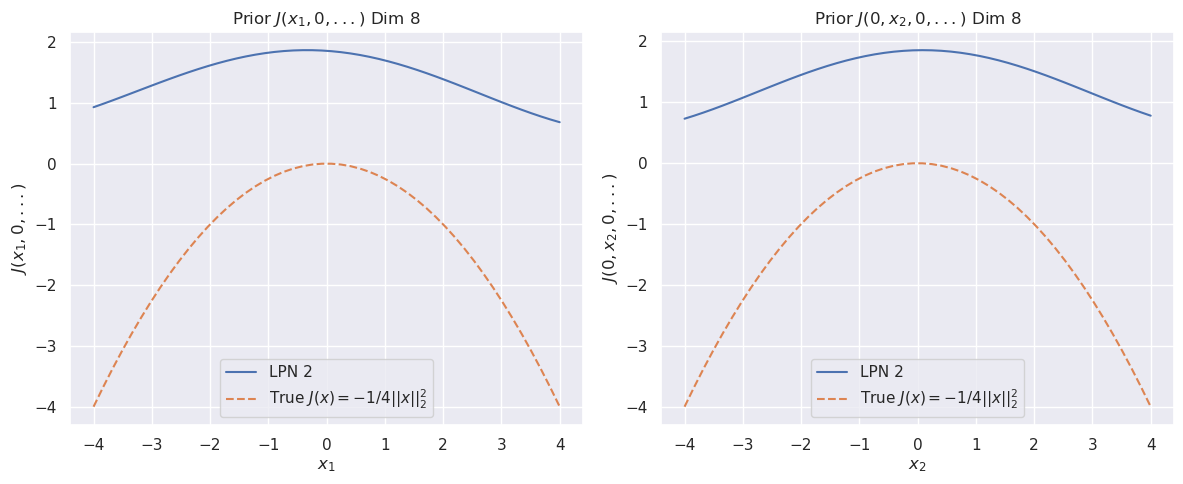

In [11]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    # Get G(x) from the second LPN model
    G_x = model_G.scalar(x_tensor)
    
    # Compute 0.5 * ||x||^2
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.25 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    #plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)